**Summary**

In this project, I created a Convolutional Neural Network model to identify metastatic cancer in small image patches taken from larger digital pathology scans. The model achieved great scores for accuracy (90%), precision (90%), recall (90%), F1-score (90%) and Auc score (96%). 

**The dataset**

The data for this competition is a slightly modified version of the PatchCamelyon (PCam) benchmark dataset (the original PCam dataset contains duplicate images due to its probabilistic sampling, however, the version presented on Kaggle does not contain duplicates).
[PCam] packs the clinically-relevant task of metastasis detection into a straight-forward binary image classification task, akin to CIFAR-10 and MNIST. Models can easily be trained on a single GPU in a couple hours, and achieve competitive scores in the Camelyon16 tasks of tumor detection and whole-slide image diagnosis. Furthermore, the balance between task-difficulty and tractability makes it a prime suspect for fundamental machine learning research on topics as active learning, model uncertainty, and explainability.

**Importing libraries**

In [1]:
import numpy as np 
import pandas as pd 

import os
for dirname, _, filenames in os.walk('../input/histopathologic-cancer-detectiont'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [2]:
from numpy.random import seed
seed(101)

import pandas as pd
import numpy as np


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam

import os
import cv2

from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import itertools
import shutil
import matplotlib.pyplot as plt
%matplotlib inline
tf.random.set_seed(101)

**Setting prerequisites**

In [3]:
img_size=96
img_ch=3
sample_size=50000  

**Exploring the directory**

In [4]:
os.listdir('../input/histopathologic-cancer-detection')

['sample_submission.csv', 'train_labels.csv', 'test', 'train']

**Data exploration**

In [5]:
print(len(os.listdir('../input/histopathologic-cancer-detection/train')))
print(len(os.listdir('../input/histopathologic-cancer-detection/test')))

220025
57458


In [6]:
df_data = pd.read_csv('../input/histopathologic-cancer-detection/train_labels.csv')

# removing this image because it caused a training error previously
df_data[df_data['id'] != 'dd6dfed324f9fcb6f93f46f32fc800f2ec196be2']

# removing this image because it's black
df_data[df_data['id'] != '9369c7278ec8bcc6c880d99194de09fc2bd4efbe']

print(df_data.shape)

(220025, 2)


In [7]:
df_data['label'].value_counts()

0    130908
1     89117
Name: label, dtype: int64

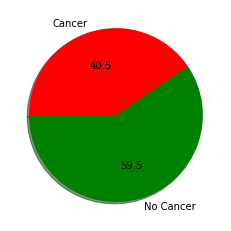

<Figure size 1080x1080 with 0 Axes>

In [8]:
labels_count = df_data.label.value_counts()

%matplotlib inline
plt.pie(labels_count, labels=['No Cancer', 'Cancer'], startangle=180, 
        autopct='%1.1f', colors=['green','red'], shadow=True)
plt.figure(figsize=(15,15))
plt.show()

**Create the Train and Validation Sets**

In [9]:
df_0=df_data[df_data['label']==0].sample(sample_size,random_state=101)
df_1=df_data[df_data['label']==1].sample(sample_size,random_state=101)

# concat the dataframes
df_data = pd.concat([df_0, df_1], axis=0).reset_index(drop=True)
# shuffle
df_data = shuffle(df_data)

df_data['label'].value_counts()

1    50000
0    50000
Name: label, dtype: int64

Data splitting

In [10]:
y = df_data['label']

df_train, df_val = train_test_split(df_data, test_size=0.10, random_state=101, stratify=y)

print(df_train.shape)
print(df_val.shape)

(90000, 2)
(10000, 2)


**Creating a new directory for the ImageDataGenerator**

Let's create 2 folders inside 'base_dir':
1.train_dir: it contains:
    # healthy_tissue
    # tumor_tissue

2.val_dir: it contains:
    # healthy_tissue
    # tumor_tissue

In [11]:
base_dir='base_dir'
os.mkdir(base_dir)


# create a path to 'base_dir' to which we will join the names of the new folders
# train_dir
train_dir = os.path.join(base_dir, 'train_dir')
os.mkdir(train_dir)

# val_dir
val_dir = os.path.join(base_dir, 'val_dir')
os.mkdir(val_dir)


# [CREATE FOLDERS INSIDE THE TRAIN AND VALIDATION FOLDERS]
# Inside each folder we create seperate folders for each class

# create new folders inside train_dir
train_healthy_tissue_dir = os.path.join(train_dir, 'healthy_tissue')
os.mkdir(train_healthy_tissue_dir)
train_tumor_tissue_dir = os.path.join(train_dir, 'tumor_tissue')
os.mkdir(train_tumor_tissue_dir)


# create new folders inside val_dir
test_healthy_tissue_dir = os.path.join(val_dir, 'healthy_tissue')
os.mkdir(test_healthy_tissue_dir)
test_tumor_tissue_dir = os.path.join(val_dir, 'tumor_tissue')
os.mkdir(test_tumor_tissue_dir)

In [12]:
# check that the folders have been created
os.listdir('base_dir/train_dir')

['tumor_tissue', 'healthy_tissue']

In [13]:
# Set the id as the index in df_data
df_data.set_index('id', inplace=True)

In [14]:
# Get a list of train and val images
train_list = list(df_train['id'])
val_list = list(df_val['id'])

In [15]:
# Transfer the train images

for image in train_list:
    
    # the id in the csv file does not have the .tif extension therefore we add it here
    fname = image + '.tif'
    # get the label for a certain image
    target = df_data.loc[image,'label']
    
    # these must match the folder names
    if target == 0:
        label = 'healthy_tissue'
    if target == 1:
        label = 'tumor_tissue'
    
    # source path to image
    src = os.path.join('../input/histopathologic-cancer-detection/train', fname)
    # destination path to image
    dst = os.path.join(train_dir, label, fname)
    # copy the image from the source to the destination
    shutil.copyfile(src, dst)


# Transfer the val images

for image in val_list:
    
    # the id in the csv file does not have the .tif extension therefore we add it here
    fname = image + '.tif'
    # get the label for a certain image
    target = df_data.loc[image,'label']
    
    # these must match the folder names
    if target == 0:
        label = 'healthy_tissue'
    if target == 1:
        label = 'tumor_tissue'
    

    # source path to image
    src = os.path.join('../input/histopathologic-cancer-detection/train', fname)
    # destination path to image
    dst = os.path.join(val_dir, label, fname)
    # copy the image from the source to the destination
    shutil.copyfile(src, dst)

In [16]:
# check how many train images we have in each folder

print(len(os.listdir('base_dir/train_dir/healthy_tissue')))
print(len(os.listdir('base_dir/train_dir/tumor_tissue')))

45000
45000


In [17]:
# check how many val images we have in each folder

print(len(os.listdir('base_dir/val_dir/healthy_tissue')))
print(len(os.listdir('base_dir/val_dir/tumor_tissue')))

5000
5000


**Data visualization**

In [18]:
#training
train_tumor_names = os.listdir(train_tumor_tissue_dir)
print(train_tumor_names[:5])
train_healthy_names = os.listdir(train_healthy_tissue_dir)
print(train_healthy_names[:5])
#test
test_tumor_names = os.listdir(test_tumor_tissue_dir)
print(test_tumor_names[:5])
test_healthy_names = os.listdir(test_healthy_tissue_dir)
print(test_healthy_names[:5])

['603bfafe49c76100c3f0543b007331b932b62ee3.tif', '84ee2e5fdb7676b1ee1c69ec056d5197d348ac26.tif', '0c4968291de493fd38e7ccedc33599857791a758.tif', '71b5bb710ce1f9c7bb7cdf4af8944ac6582ba088.tif', 'f2abd96133f34f2f9db00ef8e9599f84edc23c07.tif']
['5a9fe0e53747859b16659067c265fc46ca789810.tif', 'd9ca1ab4f7372181e3960541708604ebe80e2200.tif', '44952c84ae3830a7584f995646a8b7a73ee64037.tif', '91463e70d90d29e9c81068738e0b6feb53925a86.tif', '5fca7a514582de9bfb13956525b20025282792fd.tif']
['526f1b93de76e2b44a13a0c260a1079acc97f90e.tif', 'd9cf4e1aa69e93c5f2867f66122c842d7aaadfc4.tif', 'b428975f1e90dabbb6c984bde642255d2e4e394b.tif', '0c7553714691ea6180cf90c7c675463162732532.tif', 'fdb98192ee7854ed0136dd6f644d3740d15b20f7.tif']
['1ad84edfece5912b8e1d7bc7a0f04bfcb7d758be.tif', '46ec226cf641bf93221385bf13a0be63419943a7.tif', '824e74a36bf96b8a4a027fd55687679df8edab09.tif', '6f7d26caa323d9448aa34cbbb228d3e763b73e7a.tif', '993e11f09f4c37e374ef80d38c48accdfb083470.tif']


In [23]:
#get the filenames from the healthy and tumor dir of the train dataset
healthy_pic =[os.path.join(train_healthy_tissue_dir, filename) for filename in train_healthy_names[0:4]]
tumor_pic =[os.path.join(train_tumor_tissue_dir, filename) for filename in train_tumor_names[0:4]]

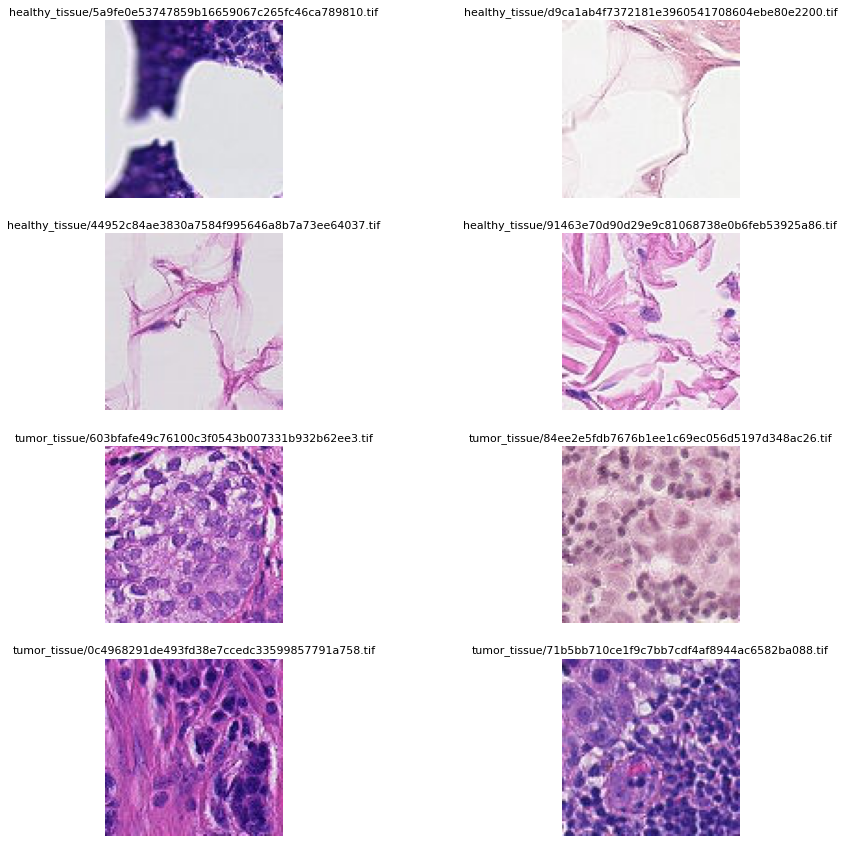

In [24]:
import matplotlib.pyplot as plt
# plot a grid of 8 images (4 images of each class)
import matplotlib.image as mpimg
#set the number of columns and rows
rows = 4
cols = 2
#set the figure size
fig = plt.gcf()
fig.set_size_inches(15,15)
#merge the covid and normal list
merged_list = healthy_pic+tumor_pic
for i , img_path in enumerate(merged_list):
  data= img_path.split('/', 2)[2] 
  sp = plt.subplot(rows, cols, i + 1)
  sp.axis('Off')
  img = mpimg.imread(img_path)
  sp.set_title(data, fontsize=11)
  plt.imshow(img,cmap='gray')

  plt.show

**Data Augmentation**

The amount of data gathered was very low and could cause the models to under-fit. Hence, we would use a brilliant technique of Data Augmentation to increase the amount of data. This technique relies on rotations, flips, change in exposure, etc to create similar images. Using this technique we can increase the size of data by a high factor. The output image of the cropping stage is given as input to ImageDataGenerator which is a function in keras.preprocessing.image library. This function takes multiple arguments that decide how Augmentation takes place.

In [25]:
# Set up the generators
train_path = 'base_dir/train_dir'
valid_path = 'base_dir/val_dir'
test_path = '../input/histopathologic-cancer-detection/test'

num_train_samples = len(df_train)
num_val_samples = len(df_val)
train_batch_size = 10
val_batch_size = 10


train_steps = np.ceil(num_train_samples / train_batch_size)
val_steps = np.ceil(num_val_samples / val_batch_size)
datagen = ImageDataGenerator(rescale=1.0/255)

train_gen = datagen.flow_from_directory(train_path,
                                        target_size=(img_size,img_size),
                                        batch_size=train_batch_size,
                                        class_mode='categorical')

val_gen = datagen.flow_from_directory(valid_path,
                                        target_size=(img_size,img_size),
                                        batch_size=val_batch_size,
                                        class_mode='categorical')

# Note: shuffle=False causes the test dataset to not be shuffled
test_gen = datagen.flow_from_directory(valid_path,
                                        target_size=(img_size,img_size),
                                        batch_size=1,
                                        class_mode='categorical',
                                        shuffle=False)

Found 90000 images belonging to 2 classes.
Found 10000 images belonging to 2 classes.
Found 10000 images belonging to 2 classes.


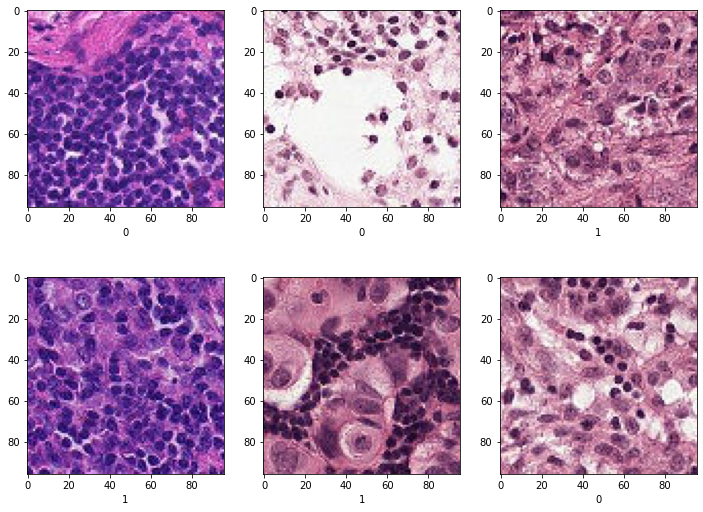

In [26]:
from tensorflow.keras.preprocessing import image
sample_x,sample_y = next(train_gen)
plt.figure(figsize=(12,9))
for i in range(6):
    plt.subplot(2,3,i+1)
    sample = image.array_to_img(sample_x[i])
    plt.xlabel(np.argmax(sample_y[i]))
    plt.imshow(sample)
plt.show()

In [27]:
#get the class indices
train_gen.class_indices

{'healthy_tissue': 0, 'tumor_tissue': 1}

In [28]:
#get the image shape
train_gen.image_shape

(96, 96, 3)

**Model Building & Training**

So until now we have cleaned, pre-processed, augmented, pickled the data and now we are ready to feed it to a ‘Neural Network’ and see how it performs. We will try to perform image classification task by using a CNN model.

**CNN model**

I used a great CNN architecture which consisted of four convolutional layers (256, 128, 128, and 64 filters), one flatten layer and four fully connected layers (128, 64, 8 and 2 neurons). To achieve a better understanding of the model, I considered as metric not only accuracy, but I added Precision, Recall, Auc score and F1 score for each epoch.

In [29]:
import tensorflow as tf
from tensorflow.python.keras import Sequential
from tensorflow.keras import layers, optimizers
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
import tensorflow.keras.backend as K

In [38]:
model = Sequential()
# add the convolutional layer
# filters, size of filters,padding,activation_function,input_shape
model.add(Conv2D(256,(3,3), padding='SAME', activation='relu', input_shape=(96,96,3)))
# pooling layer
model.add(MaxPooling2D(pool_size=(2,2)))
# place a dropout layer
model.add(Dropout(0.2))
# add the second convolutional layer
model.add(Conv2D(128,(3,3), padding='SAME', activation='relu'))
# pooling layer
model.add(MaxPooling2D(pool_size=(2,2)))
# place a dropout layer
model.add(Dropout(0.2))
# add the third convolutional layer
model.add(Conv2D(128,(2,2), padding='SAME', activation='relu'))
# pooling layer
model.add(MaxPooling2D(pool_size=(1,1)))
# place a dropout layer
model.add(Dropout(0.2))
# add the fourth convolutional layer
model.add(Conv2D(64,(1,1), padding='SAME', activation='relu'))
# pooling layer
model.add(MaxPooling2D(pool_size=(1,1)))
# place a dropout layer
model.add(Dropout(0.2))
# Flatten layer
model.add(Flatten())
# add three dense layers : amount of nodes, activation
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(8,activation='relu'))
# place a dropout layer
# 0.5 drop out rate is recommended, half input nodes will be dropped at each update
model.add(Dropout(0.5))
model.add(Dense(2,activation='softmax'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 96, 96, 256)       7168      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 48, 48, 256)       0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 48, 48, 256)       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 48, 48, 128)       295040    
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 24, 24, 128)       0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 24, 24, 128)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 24, 24, 128)      

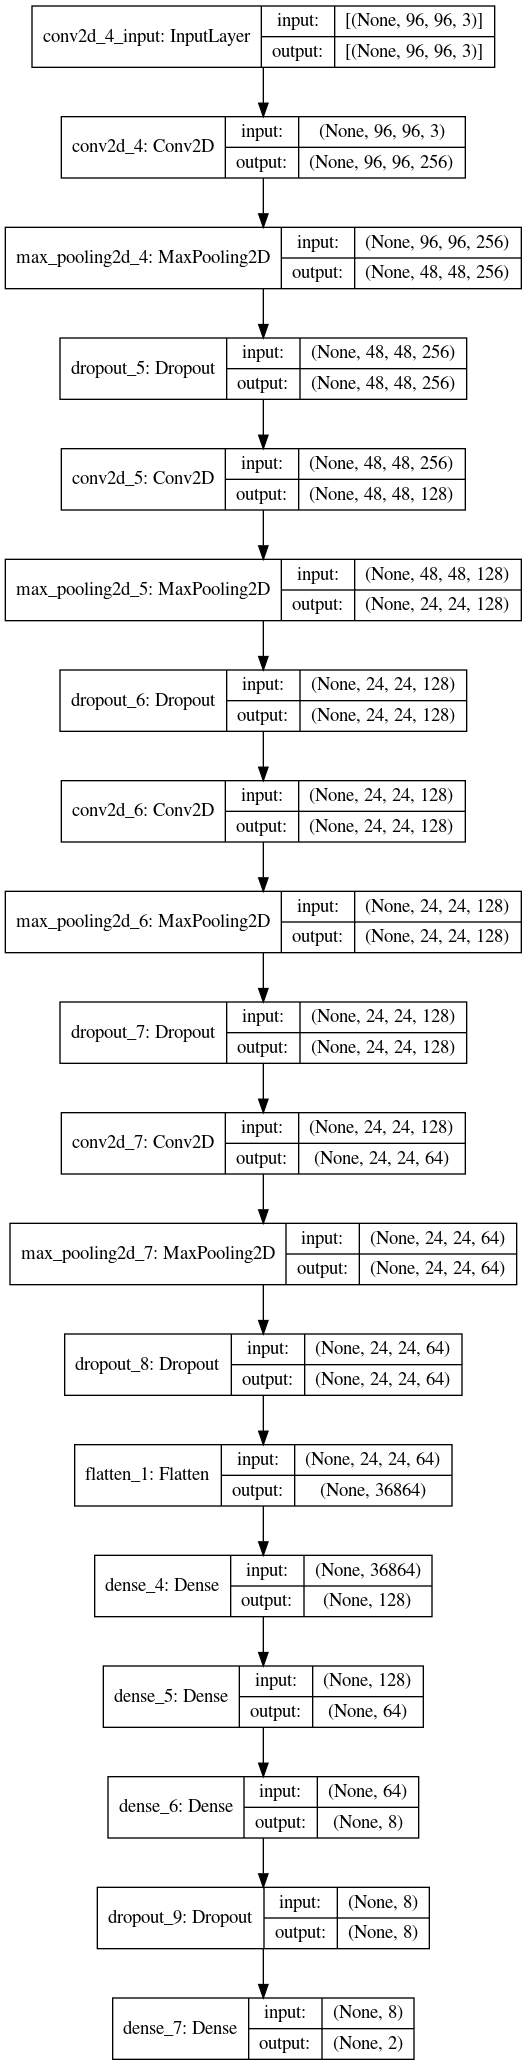

In [39]:

from tensorflow.keras.utils import plot_model
plot_model(model, 'CNN-model.png', show_shapes=True)

**Compile & Train the CNN Model**

To amplify our understanding of the model and its performance, we assess different metrics: loss function, accuracy, precision, recall anmd F1 scores.

In [40]:
def f1_score(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [41]:
import tensorflow as tf
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report

**Let's define the metrics**

In [42]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),  
      tf.keras.metrics.AUC(name='auc'),
        f1_score,
]

In [43]:
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1 **(epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(0.01, 5) # when i run it for 50 epochs

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(exponential_decay_fn)

In [44]:
model.compile(Adam(lr=0.0001),loss='binary_crossentropy',metrics=METRICS)

**Training the model**

In [ ]:
filepath = "CNN-model"

#callbacks

checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, 
                             save_best_only=True, mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_acc', factor=0.5, patience=2, 
                                   verbose=1, mode='max', min_lr=0.00001)
                              
                              
callbacks_list = [checkpoint, reduce_lr]

history = model.fit(train_gen, steps_per_epoch=train_steps, 
                    validation_data=val_gen,
                    validation_steps=val_steps,
                    epochs=50, verbose=1,
                    callbacks=callbacks_list)

Epoch 1/50
9000/9000 [==============================] - 147s 16ms/step - loss: 0.2459 - accuracy: 0.8791 - precision: 0.8791 - recall: 0.8791 - auc: 0.9599 - f1_score: 0.8791 - val_loss: 0.2405 - val_accuracy: 0.9026 - val_precision: 0.9026 - val_recall: 0.9026 - val_auc: 0.9638 - val_f1_score: 0.9026
Epoch 2/50
9000/9000 [==============================] - 146s 16ms/step - loss: 0.2325 - accuracy: 0.8838 - precision: 0.8838 - recall: 0.8838 - auc: 0.9635 - f1_score: 0.8838 - val_loss: 0.3873 - val_accuracy: 0.8176 - val_precision: 0.8176 - val_recall: 0.8176 - val_auc: 0.9073 - val_f1_score: 0.8176
Epoch 3/50
9000/9000 [==============================] - 147s 16ms/step - loss: 0.2197 - accuracy: 0.8907 - precision: 0.8907 - recall: 0.8907 - auc: 0.9671 - f1_score: 0.8907 - val_loss: 0.2524 - val_accuracy: 0.9037 - val_precision: 0.9037 - val_recall: 0.9037 - val_auc: 0.9588 - val_f1_score: 0.9037
Epoch 4/50
9000/9000 [==============================] - 146s 16ms/step - loss: 0.2101 - acc

**Model Performance Evaluation**

In [ ]:
#get the keys of history object

history.history.keys()

In [ ]:
def Train_Val_Plot(acc,val_acc,loss,val_loss,auc,val_auc,precision,val_precision,f1,val_f1):
  fig, (ax1, ax2,ax3,ax4,ax5) = plt.subplots(1,5, figsize= (20,5))
  fig.suptitle(" MODEL METRICS VISUALIZATION ")
  ax1.plot(range(1, len(acc) + 1), acc)
  ax1.plot(range(1, len(val_acc) + 1), val_acc)
  ax1.set_title('History of Accuracy')
  ax1.set_xlabel('Epochs')
  ax1.set_ylabel('Accuracy')
  ax1.legend(['training', 'validation'])
  ax2.plot(range(1, len(loss) + 1), loss)
  ax2.plot(range(1, len(val_loss) + 1), val_loss)
  ax2.set_title('History of Loss')
  ax2.set_xlabel('Epochs')
  ax2.set_ylabel('Loss')
  ax2.legend(['training', 'validation'])
    
  ax3.plot(range(1, len(auc) + 1), auc)
  ax3.plot(range(1, len(val_auc) + 1), val_auc)
  ax3.set_title('History of AUC')
  ax3.set_xlabel('Epochs')
  ax3.set_ylabel('AUC')
  ax3.legend(['training', 'validation'])

  ax4.plot(range(1, len(precision) + 1), precision)
  ax4.plot(range(1, len(val_precision) + 1), val_precision)
  ax4.set_title('History of Precision')
  ax4.set_xlabel('Epochs')
  ax4.set_ylabel('Precision')
  ax4.legend(['training', 'validation'])
    
  ax5.plot(range(1, len(f1) + 1), f1)
  ax5.plot(range(1, len(val_f1) + 1), val_f1)
  ax5.set_title('History of F1-score')
  ax5.set_xlabel('Epochs')
  ax5.set_ylabel('F1 score')
  ax5.legend(['training', 'validation'])


  plt.show()

Train_Val_Plot(history.history['accuracy'],history.history['val_accuracy'],
                 history.history['loss'],history.history['val_loss'],
                 history.history['auc'],history.history['val_auc'],
                 history.history['precision'],history.history['val_precision'],
                 history.history['f1_score'],history.history['val_f1_score']
                 )

In [ ]:
# Get the labels that are associated with each index
print(val_gen.class_indices)

In [ ]:
# get the metric names so we can use evaulate_generator
model.metrics_names

In [ ]:
scores = model.evaluate(test_gen)

In [ ]:
print("CNN Accuracy = ", scores[1])
print("CNN Precision = ", scores[2])
print("CNN Recall = ", scores[3])
print("CNN AUC = ", scores[4])
print("CNN F1_score = ", scores[5])

As we can see, we achieved a good overall performance for all the metrics! So we can conclude that our CNN model could be a good piece of work in histopathology for classification tasks.